In [156]:
import pandas as pd
import numpy as np 
from tqdm.auto import tqdm
import joblib
import itertools

# 시각화
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib.font_manager as fm

# 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GroupKFold, KFold, StratifiedKFold, TimeSeriesSplit

# 모델링
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn import tree

import eli5
from eli5.sklearn import PermutationImportance
import wandb

import warnings
warnings.filterwarnings('ignore')

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

In [157]:
file_path = '/data/ephemeral/home/aistages_ml/upstage-ml-regression-07/house_price_pred/data/interim/total-data_ver2.csv'
df_all = pd.read_csv(file_path)

### 사용하기로 한 Feature 뽑기

In [158]:
picked_cols = ["index", "복도유형", '난방방식', "전용면적", "층", '건축년도', 'x', "y", '아파트명', '계약년월', 'mean_지상층수', 'sum_세대수', 'sum_연면적', 'mean_연면적', 'sum_건축면적', 'mean_건축면적', '부속건축물수', 'target', '시군구', '한강거리', '기준금리', 'dist_to_nearest_school', 'bus_count_500', 'bus_count_1000', '대장아파트_거리', 'is_test', '이전가격', '최고층', '최저층', '빌딩간격', '거래날차이', '2020_ratio', '이전가격_check']
df_all = df_all[picked_cols]

In [159]:
df_all[['시', '구', '동']] = df_all['시군구'].str.split(' ', expand=True)
del df_all['시군구']
del df_all['시']
display(df_all)

,index,복도유형,난방방식,전용면적,층,건축년도,x,y,아파트명,계약년월,...,is_test,이전가격,최고층,최저층,빌딩간격,거래날차이,2020_ratio,이전가격_check,구,동
0,183878,계단식,개별난방,59.89,2,2005,126.798318,37.573351,방화3차우림필유,200701,...,0,30900.0,15,1,14,0.0,37.465235,19000.0,강서구,방화동
1,183876,계단식,개별난방,59.89,2,2005,126.798318,37.573351,방화3차우림필유,200805,...,0,30000.0,15,1,14,-3.0,37.465235,19000.0,강서구,방화동
2,183760,계단식,개별난방,59.89,7,2005,126.798318,37.573351,방화3차우림필유,200810,...,0,39850.0,15,1,14,149.0,37.465235,30900.0,강서구,방화동
3,183761,계단식,개별난방,59.89,8,2005,126.798318,37.573351,방화3차우림필유,200902,...,0,38000.0,15,1,14,127.0,37.465235,38000.0,강서구,방화동
4,183763,계단식,개별난방,59.89,2,2005,126.798318,37.573351,방화3차우림필유,200907,...,0,29200.0,15,1,14,-2.0,37.465235,29200.0,강서구,방화동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,69209,혼합식,지역난방,114.81,11,2009,127.179998,37.559208,강일리버파크10단지,202005,...,0,85000.0,15,1,14,97.0,41.596165,85000.0,강동구,강일동
1128090,69194,혼합식,지역난방,114.81,9,2009,127.179998,37.559208,강일리버파크10단지,202102,...,0,49950.0,15,1,14,-11.0,41.596165,92000.0,강동구,강일동
1128091,69195,혼합식,지역난방,114.81,3,2009,127.179998,37.559208,강일리버파크10단지,202102,...,0,93500.0,15,1,14,188.0,41.596165,93500.0,강동구,강일동
1128092,574,혼합식,지역난방,114.81,8,2009,127.179998,37.559208,강일리버파크10단지,202308,...,1,57000.0,15,1,14,72.0,41.596165,135000.0,강동구,강일동


In [160]:
df_train = df_all[df_all['is_test'] == 0]
df_test = df_all[df_all['is_test'] == 1]

df_train = df_train.sort_values(by='index').set_index('index').rename_axis(None)
df_test = df_test.sort_values(by='index').set_index('index').rename_axis(None)

df_all = pd.concat([df_train, df_test])
df_all = df_all.reset_index(drop=True)
display(df_all)

,복도유형,난방방식,전용면적,층,건축년도,x,y,아파트명,계약년월,mean_지상층수,...,is_test,이전가격,최고층,최저층,빌딩간격,거래날차이,2020_ratio,이전가격_check,구,동
0,계단식,개별난방,79.97,3,1987,127.057210,37.476763,개포6차우성,201712,5.00,...,0,124000.0,5,1,4,-20.0,74.687709,117500.0,강남구,개포동
1,계단식,개별난방,79.97,4,1987,127.057210,37.476763,개포6차우성,201712,5.00,...,0,124000.0,5,1,4,152.0,74.687709,124000.0,강남구,개포동
2,계단식,개별난방,54.98,5,1987,127.057210,37.476763,개포6차우성,201712,5.00,...,0,91500.0,5,1,4,6.0,74.687709,90000.0,강남구,개포동
3,계단식,개별난방,79.97,4,1987,127.057210,37.476763,개포6차우성,201801,5.00,...,0,123500.0,5,1,4,26.0,74.687709,123500.0,강남구,개포동
4,계단식,개별난방,79.97,2,1987,127.057210,37.476763,개포6차우성,201801,5.00,...,0,130000.0,5,1,4,5.0,74.687709,130000.0,강남구,개포동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,복도식,개별난방,49.77,7,1996,127.093511,37.616533,신내6대주,202307,11.25,...,1,15600.0,12,3,9,7.0,31.197193,NaN,중랑구,신내동
1128090,복도식,개별난방,39.84,3,1996,127.093511,37.616533,신내6대주,202308,11.25,...,1,13500.0,12,3,9,16.0,31.197193,NaN,중랑구,신내동
1128091,혼합식,개별난방,59.76,4,1996,127.093511,37.616533,신내6대주,202308,11.25,...,1,23500.0,12,3,9,10.0,31.197193,NaN,중랑구,신내동
1128092,복도식,개별난방,39.84,9,1996,127.093511,37.616533,신내6대주,202309,11.25,...,1,13500.0,12,3,9,16.0,31.197193,NaN,중랑구,신내동


## 1. Target 값의 이상치를 파악할 수 있는 컬럼 확인

    - train : 2020~
    - target : 2023

In [161]:
numeric_cols = df_all.select_dtypes(np.number)
categorical_cols = df_all.select_dtypes('object')

display(numeric_cols)
display(categorical_cols)

,전용면적,층,건축년도,x,y,계약년월,mean_지상층수,sum_세대수,sum_연면적,mean_연면적,...,bus_count_1000,대장아파트_거리,is_test,이전가격,최고층,최저층,빌딩간격,거래날차이,2020_ratio,이전가격_check
0,79.97,3,1987,127.057210,37.476763,201712,5.00,270.0,21960.54,2745.06750,...,45,5.516266,0,124000.0,5,1,4,-20.0,74.687709,117500.0
1,79.97,4,1987,127.057210,37.476763,201712,5.00,270.0,21960.54,2745.06750,...,45,5.516266,0,124000.0,5,1,4,152.0,74.687709,124000.0
2,54.98,5,1987,127.057210,37.476763,201712,5.00,270.0,21960.54,2745.06750,...,45,5.516266,0,91500.0,5,1,4,6.0,74.687709,90000.0
3,79.97,4,1987,127.057210,37.476763,201801,5.00,270.0,21960.54,2745.06750,...,45,5.516266,0,123500.0,5,1,4,26.0,74.687709,123500.0
4,79.97,2,1987,127.057210,37.476763,201801,5.00,270.0,21960.54,2745.06750,...,45,5.516266,0,130000.0,5,1,4,5.0,74.687709,130000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,49.77,7,1996,127.093511,37.616533,202307,11.25,1609.0,127417.74,7963.60875,...,44,2.134842,1,15600.0,12,3,9,7.0,31.197193,NaN
1128090,39.84,3,1996,127.093511,37.616533,202308,11.25,1609.0,127417.74,7963.60875,...,44,2.134842,1,13500.0,12,3,9,16.0,31.197193,NaN
1128091,59.76,4,1996,127.093511,37.616533,202308,11.25,1609.0,127417.74,7963.60875,...,44,2.134842,1,23500.0,12,3,9,10.0,31.197193,NaN
1128092,39.84,9,1996,127.093511,37.616533,202309,11.25,1609.0,127417.74,7963.60875,...,44,2.134842,1,13500.0,12,3,9,16.0,31.197193,NaN


,복도유형,난방방식,아파트명,구,동
0,계단식,개별난방,개포6차우성,강남구,개포동
1,계단식,개별난방,개포6차우성,강남구,개포동
2,계단식,개별난방,개포6차우성,강남구,개포동
3,계단식,개별난방,개포6차우성,강남구,개포동
4,계단식,개별난방,개포6차우성,강남구,개포동
...,...,...,...,...,...
1128089,복도식,개별난방,신내6대주,중랑구,신내동
1128090,복도식,개별난방,신내6대주,중랑구,신내동
1128091,혼합식,개별난방,신내6대주,중랑구,신내동
1128092,복도식,개별난방,신내6대주,중랑구,신내동


### Target값 과의 상관관계가 높은 컬럼 확인

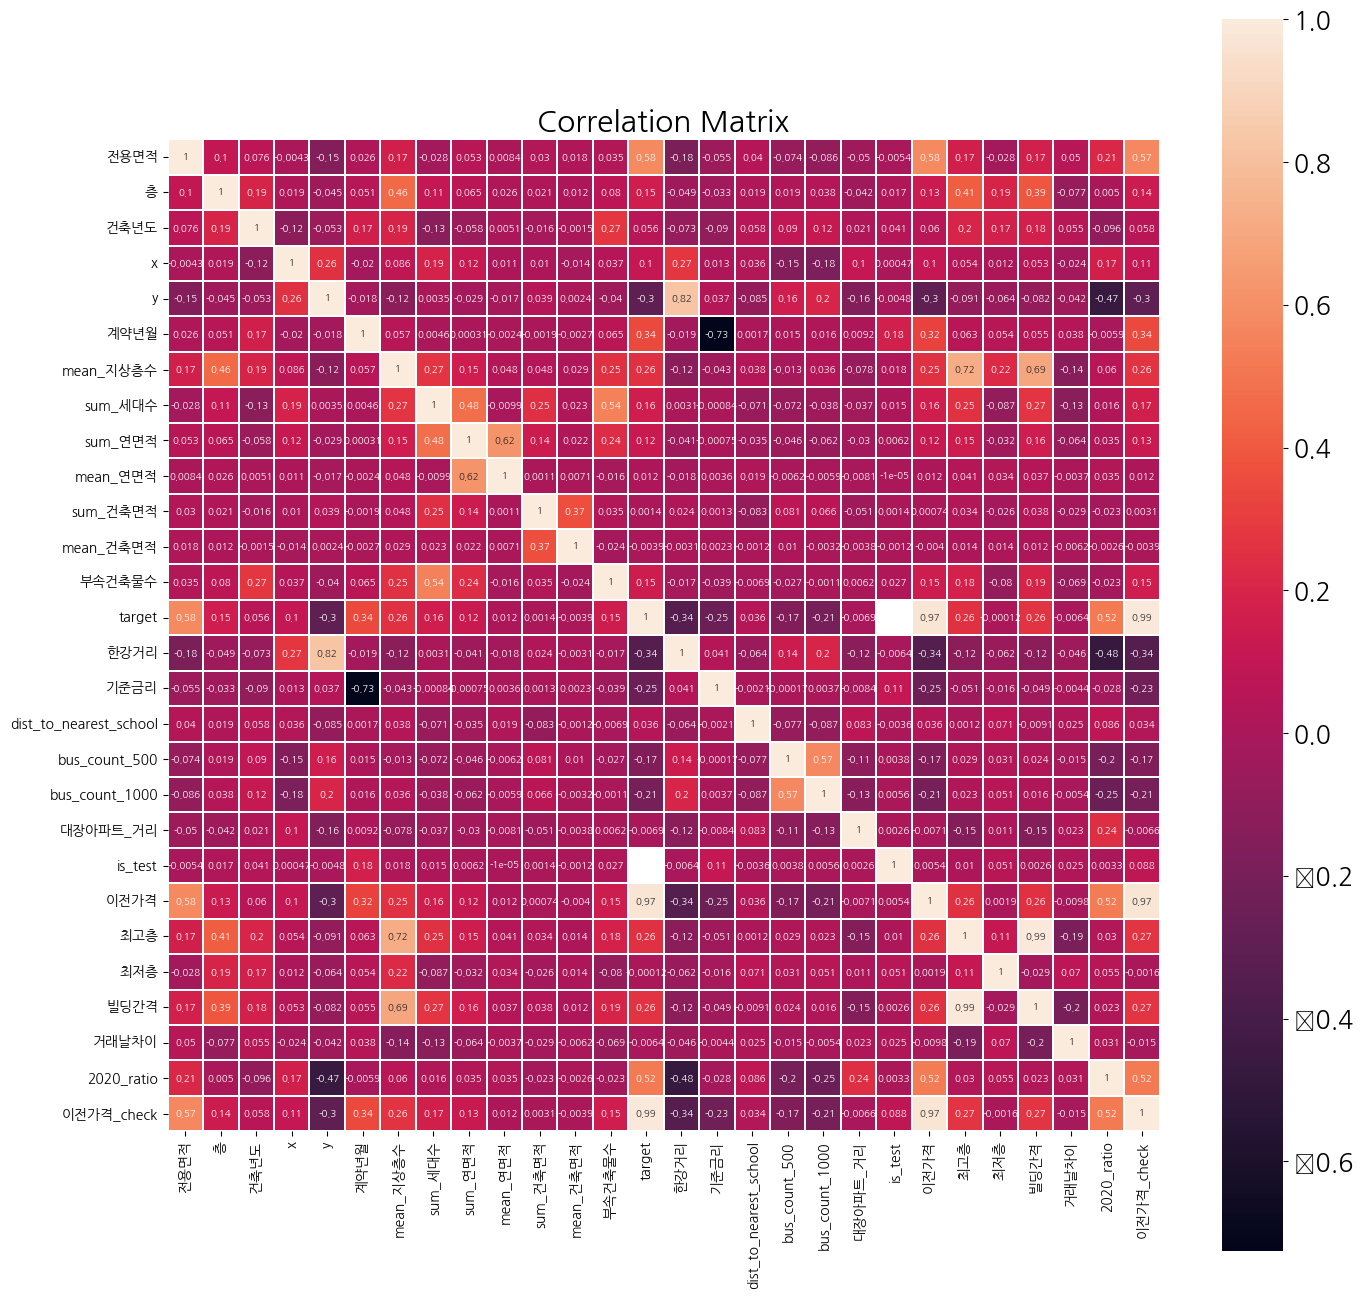

In [162]:
plt.figure(figsize=(16, 16))
corr = df_all.corr()
sns.heatmap(corr, annot=True, annot_kws={'size':7}, fmt='.2g', linewidths=0.2, square=True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Correlation Matrix')
plt.show()

- 전용면적과 target과의 상관관계 : 0.58
- 이전가격과 target과의 상관관계 : 0.97
- 이전가격_check과 target과의 상관관계 : 0.99 (하지만 사용하려면 결측치 처리를 어떻게 해야할지 생각해야함)

In [163]:
df_all.isnull().sum()

복도유형                         0
난방방식                         0
전용면적                         0
층                            0
건축년도                         0
x                            0
y                            0
아파트명                         0
계약년월                         0
mean_지상층수                    0
sum_세대수                      0
sum_연면적                      0
mean_연면적                     0
sum_건축면적                     0
mean_건축면적                    0
부속건축물수                       0
target                    9272
한강거리                         0
기준금리                         0
dist_to_nearest_school       0
bus_count_500                0
bus_count_1000               0
대장아파트_거리                     0
is_test                      0
이전가격                         0
최고층                          0
최저층                          0
빌딩간격                         0
거래날차이                        0
2020_ratio                   0
이전가격_check                2253
구                            0
동       

### 전용면적

In [164]:
df_all['전용면적'].describe()

count    1.128094e+06
mean     7.716028e+01
std      2.936448e+01
min      1.002000e+01
25%      5.965000e+01
50%      8.187000e+01
75%      8.496000e+01
max      4.243200e+02
Name: 전용면적, dtype: float64

- 전용면적의 1사분위수 : 60이하
- 전용면적의 3사분위수 : 85이상

In [165]:
Q1 = df_all['전용면적'].quantile(0.25)
Q3 = df_all['전용면적'].quantile(0.75)
IQR = Q3 - Q1

df_all['전용면적_label'] = np.where(
    df_all['전용면적'] < Q1 - 1.5 * IQR, 0,
    np.where(df_all['전용면적'] > Q3 + 1.5 * IQR, 2, 1)
)
df_all['전용면적_label'].value_counts()

1    1038041
2      73408
0      16645
Name: 전용면적_label, dtype: int64

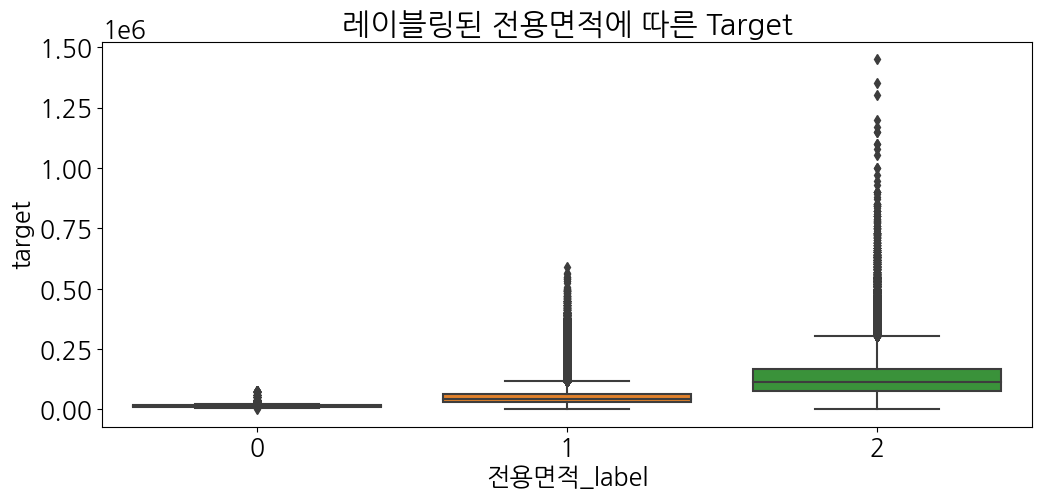

In [166]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_all, x='전용면적_label', y='target')
plt.title('레이블링된 전용면적에 따른 Target')
plt.show()

In [167]:
df_all['전용면적_range'] = pd.cut(df_all['전용면적'], 10, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
df_all['전용면적_range'].value_counts()

1    764455
0    174183
2    139681
3     39542
4      6987
5      3108
6       126
7        10
9         2
8         0
Name: 전용면적_range, dtype: int64

<Axes: xlabel='전용면적_range', ylabel='target'>

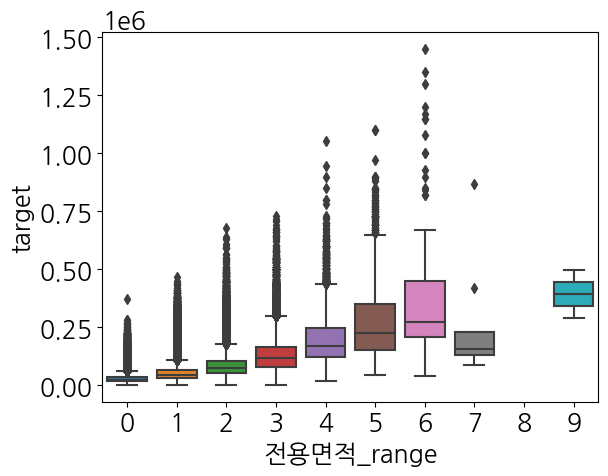

In [168]:
sns.boxplot(data=df_all, x='전용면적_range', y='target')

### 이전가격

## 2. 모델링을 통한 결과 확인하기

In [169]:
df_all = df_all.drop(columns=['이전가격_check', '전용면적_range'])

In [170]:
df_train = df_all[df_all['is_test'] == 0]
df_test = df_all[df_all['is_test'] == 1]

del df_train['is_test']
del df_test['is_test']

In [171]:
df_train['전용면적_label'].value_counts()

1    1029574
2      72858
0      16390
Name: 전용면적_label, dtype: int64

### 전용면적_label이 2인 데이터셋(전용면적이 upper bound 이상에 해당)만 훈련에 사용해서 전용면적이 큰 데이터에 대해 예측하는 모델 만들기

In [172]:
print(f"{df_train['계약년월'].min()} ~ {df_train['계약년월'].max()}")

200701 ~ 202306


In [173]:
X_train = df_train.loc[(df_train['전용면적_label'] == 2) & (df_train['계약년월'] >= 201001) & (df_train['계약년월'] < 202201)]
X_test = df_train.loc[(df_train['전용면적_label'] == 2) & (df_train['계약년월'] >= 202201)]

display(X_train)
display(X_test)

,복도유형,난방방식,전용면적,층,건축년도,x,y,아파트명,계약년월,mean_지상층수,...,대장아파트_거리,이전가격,최고층,최저층,빌딩간격,거래날차이,2020_ratio,구,동,전용면적_label
101,혼합식,지역난방,133.46,1,1984,127.055990,37.483894,개포우성3차,201710,15.000000,...,4.717465,152000.0,15,1,14,93.0,74.687709,강남구,개포동,2
102,혼합식,지역난방,161.00,8,1984,127.055990,37.483894,개포우성3차,201711,15.000000,...,4.717465,182000.0,15,1,14,29.0,74.687709,강남구,개포동,2
103,혼합식,지역난방,161.00,8,1984,127.055990,37.483894,개포우성3차,201711,15.000000,...,4.717465,182000.0,15,1,14,16.0,74.687709,강남구,개포동,2
104,혼합식,지역난방,161.00,6,1984,127.055990,37.483894,개포우성3차,201712,15.000000,...,4.717465,170000.0,15,1,14,16.0,74.687709,강남구,개포동,2
105,혼합식,지역난방,133.46,10,1984,127.055990,37.483894,개포우성3차,201712,15.000000,...,4.717465,152000.0,15,1,14,3.0,74.687709,강남구,개포동,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116541,계단식,개별난방,125.09,6,2003,127.081115,37.606134,한영,201705,16.725022,...,1.380550,36900.0,7,2,5,216.0,31.197193,중랑구,중화동,2
1116560,계단식,개별난방,125.09,6,2003,127.081115,37.606134,한영,201405,16.725022,...,1.380550,36900.0,7,2,5,-19.0,31.197193,중랑구,중화동,2
1117003,타워형,개별난방,143.28,5,1993,127.077271,37.586736,효성,201704,5.000000,...,1.768351,35000.0,5,1,4,2027.0,31.197193,중랑구,면목동,2
1117067,타워형,개별난방,143.66,7,2004,127.077387,37.613146,강오,201311,20.182688,...,2.187303,39500.0,7,3,4,1394.0,31.197193,중랑구,중화동,2


,복도유형,난방방식,전용면적,층,건축년도,x,y,아파트명,계약년월,mean_지상층수,...,대장아파트_거리,이전가격,최고층,최저층,빌딩간격,거래날차이,2020_ratio,구,동,전용면적_label
281,계단식,지역난방,168.42,2,2004,127.076624,37.496296,개포자이,202202,21.750000,...,3.962456,185000.0,22,1,21,172.0,74.687709,강남구,개포동,2
282,계단식,지역난방,170.32,11,2004,127.076624,37.496296,개포자이,202207,21.750000,...,3.962456,175000.0,22,1,21,170.0,74.687709,강남구,개포동,2
4284,계단식,개별난방,144.74,9,2004,127.038152,37.514753,동양파라곤,202210,16.000000,...,1.778452,250000.0,16,1,15,140.0,74.687709,강남구,논현동,2
4285,계단식,개별난방,157.41,9,2004,127.038152,37.514753,동양파라곤,202305,16.000000,...,1.778452,192500.0,16,1,15,-1.0,74.687709,강남구,논현동,2
4286,계단식,개별난방,180.07,1,2004,127.038152,37.514753,동양파라곤,202305,16.000000,...,1.778452,235000.0,16,1,15,226.0,74.687709,강남구,논현동,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110055,계단식,개별난방,129.37,15,1997,127.104546,37.609940,동성,202306,20.750000,...,1.771455,78500.0,23,1,22,-8.0,31.197193,중랑구,신내동,2
1111356,타워형,개별난방,134.94,10,2000,127.099854,37.602528,벽산,202304,21.333333,...,0.885488,39600.0,24,1,23,35.0,31.197193,중랑구,신내동,2
1113324,타워형,개별난방,134.37,12,1995,127.092980,37.615780,진로,202303,11.764706,...,2.049089,65000.0,12,1,11,275.0,31.197193,중랑구,신내동,2
1113344,타워형,개별난방,134.37,2,1995,127.092980,37.615780,진로,202205,11.764706,...,2.049089,75000.0,12,1,11,207.0,31.197193,중랑구,신내동,2


In [174]:
X_train = X_train.sort_values(by='계약년월').reset_index(drop=True)
X_test = X_test.sort_values(by='계약년월').reset_index(drop=True)

display(X_train)
display(X_test)

,복도유형,난방방식,전용면적,층,건축년도,x,y,아파트명,계약년월,mean_지상층수,...,대장아파트_거리,이전가격,최고층,최저층,빌딩간격,거래날차이,2020_ratio,구,동,전용면적_label
0,타워형,지역난방,173.25,4,2005,126.994102,37.493211,베로니스3차,201001,6.000000,...,1.196043,130000.0,9,1,8,87.0,74.406403,서초구,방배동,2
1,타워형,지역난방,136.34,10,1981,127.074659,37.506857,우성,201001,14.863115,...,0.000000,112500.0,18,1,17,-6.0,52.085112,송파구,잠실동,2
2,타워형,지역난방,149.74,6,1984,127.131348,37.494843,극동,201001,15.000000,...,5.176225,87000.0,15,1,14,36.0,52.085112,송파구,가락동,2
3,타워형,지역난방,242.77,2,2003,126.988803,37.492140,노블하임,201001,10.797475,...,1.544679,160000.0,15,1,14,-8.0,74.406403,서초구,방배동,2
4,타워형,개별난방,141.33,8,2009,127.087509,37.593298,주함해븐,201001,8.000000,...,0.612605,47000.0,10,2,8,106.0,31.197193,중랑구,면목동,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61577,타워형,지역난방,149.74,4,2010,127.048080,37.528723,청담파라곤Ⅱ2단지,202112,6.500000,...,0.459261,320000.0,14,-1,15,23.0,74.687709,강남구,청담동,2
61578,타워형,지역난방,243.71,5,1999,126.992857,37.490326,월드빌리지,202112,6.000000,...,1.533776,172000.0,6,1,5,1090.0,74.406403,서초구,방배동,2
61579,타워형,지역난방,161.91,18,2002,127.024400,37.498178,현대성우주상복합,202112,23.000000,...,2.241988,89500.0,24,3,21,195.0,74.406403,서초구,서초동,2
61580,타워형,지역난방,187.12,4,1999,127.114963,37.529711,현대리버빌1지구,202112,14.000000,...,4.369552,100000.0,20,1,19,67.0,52.085112,송파구,풍납동,2


,복도유형,난방방식,전용면적,층,건축년도,x,y,아파트명,계약년월,mean_지상층수,...,대장아파트_거리,이전가격,최고층,최저층,빌딩간격,거래날차이,2020_ratio,구,동,전용면적_label
0,계단식,개별난방,126.6600,11,1997,127.097110,37.538173,현대프라임,202201,28.400000,...,0.373129,196500.0,30,1,29,32.0,38.478333,광진구,구의동,2
1,혼합식,중앙난방,177.1200,11,1982,127.014156,37.539745,한남하이츠,202201,13.000000,...,2.689270,158000.0,14,1,13,184.0,48.168901,성동구,옥수동,2
2,타워형,지역난방,196.2100,9,1976,127.027436,37.533414,현대1차,202201,13.384615,...,2.327336,780000.0,15,1,14,31.0,74.687709,강남구,압구정동,2
3,계단식,개별난방,124.6250,5,2019,127.021990,37.553400,이편한세상금호파크힐스,202201,18.750000,...,2.208601,203000.0,21,1,20,18.0,48.168901,성동구,금호동1가,2
4,계단식,지역난방,126.6226,10,2018,127.002073,37.479284,방배아트자이,202201,13.000000,...,2.645190,283000.0,15,1,14,164.0,74.406403,서초구,방배동,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,계단식,개별난방,124.8000,6,2009,127.000865,37.522819,용산파크타워,202306,40.000000,...,1.371927,150000.0,40,2,38,18.0,64.923778,용산구,용산동5가,2
1881,타워형,지역난방,172.2700,10,2009,126.996352,37.490967,방배롯데캐슬로제,202306,11.000000,...,1.370567,178208.0,11,2,9,343.0,74.406403,서초구,방배동,2
1882,타워형,지역난방,130.5450,32,1999,127.051498,37.488373,대림아크로빌,202306,46.000000,...,4.208206,260000.0,46,3,43,-5.0,74.687709,강남구,도곡동,2
1883,타워형,개별난방,166.9800,3,1984,126.985157,37.518159,신동아,202306,13.000000,...,2.738939,367000.0,13,1,12,7.0,64.923778,용산구,서빙고동,2


### 모델링 전처리 --> Label Encoder

In [175]:
numeric_cols = X_train.select_dtypes(np.number)
categorical_cols = X_train.select_dtypes('object')
label_encoders = {}

for col in tqdm(categorical_cols):
    lbl = LabelEncoder()

    lbl.fit(X_train[col].astype(str))
    X_train[col] = lbl.transform(X_train[col].astype(str))
    label_encoders[col] = lbl

    for label in np.unique(X_test[col]):
        if label not in lbl.classes_:
            lbl.classes_ = np.append(lbl.classes_, label)

    X_test[col] = lbl.transform(X_test[col].astype(str))

  0%|          | 0/61582 [00:00<?, ?it/s]

In [176]:
X_train.head(1)

,복도유형,난방방식,전용면적,층,건축년도,x,y,아파트명,계약년월,mean_지상층수,...,대장아파트_거리,이전가격,최고층,최저층,빌딩간격,거래날차이,2020_ratio,구,동,전용면적_label
0,2,2,173.25,4,2005,126.994102,37.493211,649,201001,6.0,...,1.196043,130000.0,9,1,8,87.0,74.406403,14,76,2


In [177]:
assert X_train.shape[1] == X_test.shape[1]

In [178]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61582 entries, 0 to 61581
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   복도유형                    61582 non-null  int64  
 1   난방방식                    61582 non-null  int64  
 2   전용면적                    61582 non-null  float64
 3   층                       61582 non-null  int64  
 4   건축년도                    61582 non-null  int64  
 5   x                       61582 non-null  float64
 6   y                       61582 non-null  float64
 7   아파트명                    61582 non-null  int64  
 8   계약년월                    61582 non-null  int64  
 9   mean_지상층수               61582 non-null  float64
 10  sum_세대수                 61582 non-null  float64
 11  sum_연면적                 61582 non-null  float64
 12  mean_연면적                61582 non-null  float64
 13  sum_건축면적                61582 non-null  float64
 14  mean_건축면적               61582 non-null

In [179]:
target_col = 'target'
input_cols = X_train.columns.tolist()
input_cols.remove(target_col)

Y_train = X_train[target_col]
X_train = X_train[input_cols]

Y_test = X_test[target_col]
X_test = X_test[input_cols]

display(f"Train data shape : {X_train.shape}")
display(f"Train target shape : {Y_train.shape}")
display(f"Test data shape : {X_test.shape}")
display(f"Test target shape : {Y_test.shape}")

'Train data shape : (61582, 31)'

'Train target shape : (61582,)'

'Test data shape : (1885, 31)'

'Test target shape : (1885,)'

In [180]:
# 시드 고정
seed = 42
import random
import os 

def random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

random_seed(seed)

In [181]:
gbm = lgb.LGBMRegressor(n_estimators=10000, random_state=42)
gbm.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=10, show_stdv=True)])

model_name = '../models/outlier_lgbm.pkl'
joblib.dump(gbm, model_name)
model_predict = gbm.predict(X_test)
RMSE = mean_squared_error(Y_test, model_predict)**0.5
print(f"Model RMSE : {RMSE}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4677
[LightGBM] [Info] Number of data points in the train set: 61582, number of used features: 30
[LightGBM] [Info] Start training from score 135565.005278
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 37518.3	training's l2: 1.40762e+09	valid_1's rmse: 114967	valid_1's l2: 1.32173e+10
[20]	training's rmse: 24417.9	training's l2: 5.96235e+08	valid_1's rmse: 86396.4	valid_1's l2: 7.46433e+09
[30]	training's rmse: 20820.4	training's l2: 4.3349e+08	valid_1's rmse: 73801.3	valid_1's l2: 5.44663e+09
[40]	training's rmse: 19302.6	training's l2: 3.72591e+08	valid_1's rmse: 67025.3	valid_1's l2: 4.49239e+09
[50]	training's rmse: 18424.2	training's l2: 3.3945e+08	valid_1's rmse: 63985	valid_1's l2: 4.09407e+09
[60]	training's rmse: 17748.7	training's l2: 3.15017e+08	valid

In [182]:
model = joblib.load(model_name)

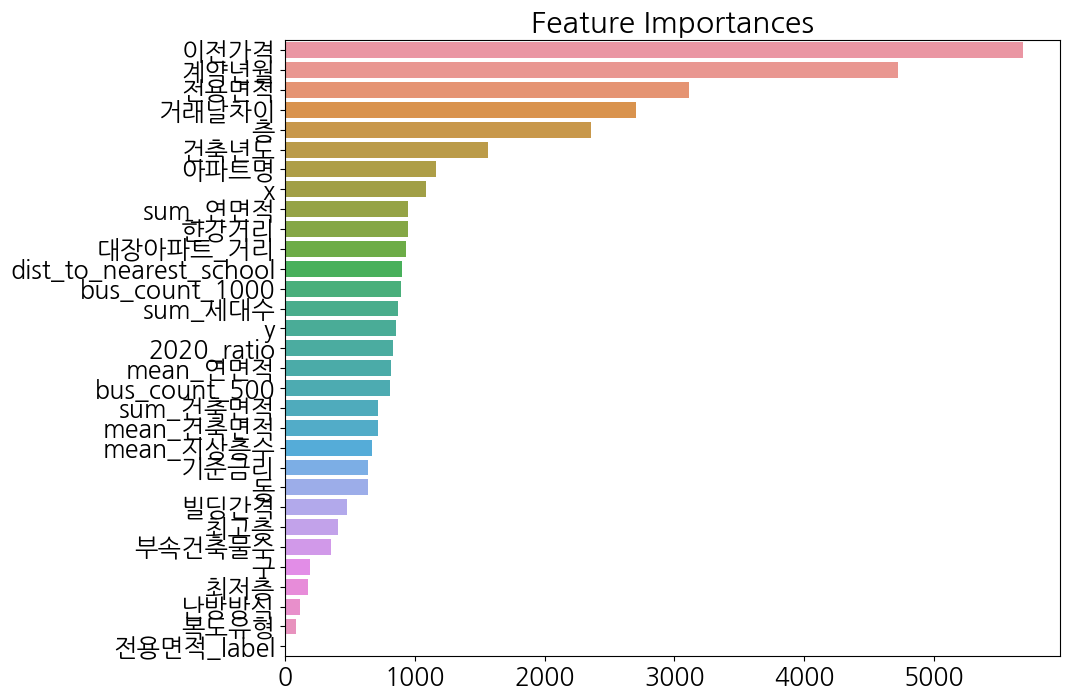

In [184]:
feat_imp = model.feature_importances_
ser_imp = pd.Series(feat_imp, index=list(input_cols))
ser_imp = ser_imp.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
sns.barplot(x=ser_imp, y=ser_imp.index)
plt.show()

In [185]:
X_test['target'] = Y_test
X_test['pred'] = model_predict

In [187]:
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

squared_errors = calculate_se(X_test['target'], X_test['pred'])
X_test['error'] = squared_errors

In [188]:
X_val_sort = X_test.sort_values(by='error', ascending=False)

In [189]:
X_val_sort.head()

,복도유형,난방방식,전용면적,층,건축년도,x,y,아파트명,계약년월,mean_지상층수,...,최저층,빌딩간격,거래날차이,2020_ratio,구,동,전용면적_label,target,pred,error
272,2,2,273.960,16,2020,127.052217,37.526214,16,202204,20.000000,...,2,18,154.0,74.687709,0,192,2,1450000.0,1.118430e+06,1.099389e+11
845,0,2,222.760,22,2009,126.999722,37.502999,403,202211,29.178571,...,1,31,26.0,74.406403,14,75,2,840000.0,5.155947e+05,1.052388e+11
769,2,0,264.546,47,2020,127.044151,37.544136,1046,202209,49.000000,...,3,44,170.0,48.168901,15,108,2,1300000.0,9.810064e+05,1.017569e+11
1871,2,0,167.210,5,1971,126.965018,37.521781,1409,202306,5.000000,...,-1,26,5.0,64.923778,20,163,2,585000.0,2.925107e+05,8.554998e+10
1098,2,2,244.320,5,2006,127.052217,37.526214,812,202303,16.000000,...,2,18,12.0,74.687709,0,192,2,821000.0,5.453843e+05,7.596400e+10


In [190]:
X_val_sort_top100 = X_test.sort_values(by='error', ascending=False).head(100)
X_val_sort_tail100 = X_test.sort_values(by='error', ascending=False).tail(100)

In [192]:
error_top100 = X_val_sort_top100.copy()
for column in categorical_cols:
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_cols:
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [195]:
display(error_top100.head(1))
display(best_top100.head(1))

,복도유형,난방방식,전용면적,층,건축년도,x,y,아파트명,계약년월,mean_지상층수,...,최저층,빌딩간격,거래날차이,2020_ratio,구,동,전용면적_label,target,pred,error
272,타워형,지역난방,273.96,16,2020,127.052217,37.526214,PH129,202204,20.0,...,2,18,154.0,74.687709,강남구,청담동,2,1450000.0,1.118430e+06,1.099389e+11


,복도유형,난방방식,전용면적,층,건축년도,x,y,아파트명,계약년월,mean_지상층수,...,최저층,빌딩간격,거래날차이,2020_ratio,구,동,전용면적_label,target,pred,error
306,계단식,개별난방,147.3454,9,2013,126.980163,37.494215,이수힐스테이트,202204,12.2,...,1,14,202.0,41.785433,동작구,동작동,2,217000.0,219414.918474,5.831831e+06


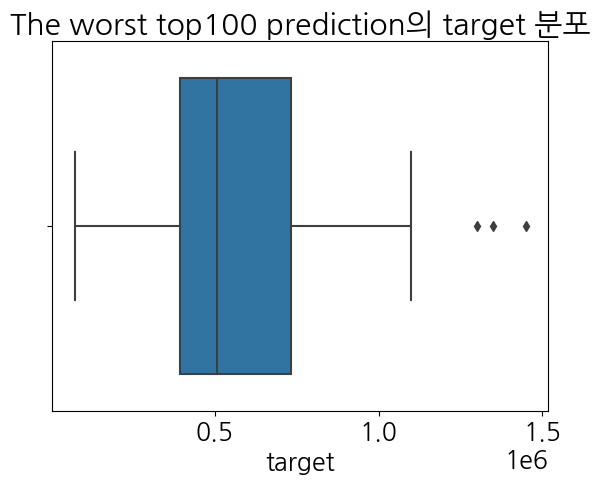

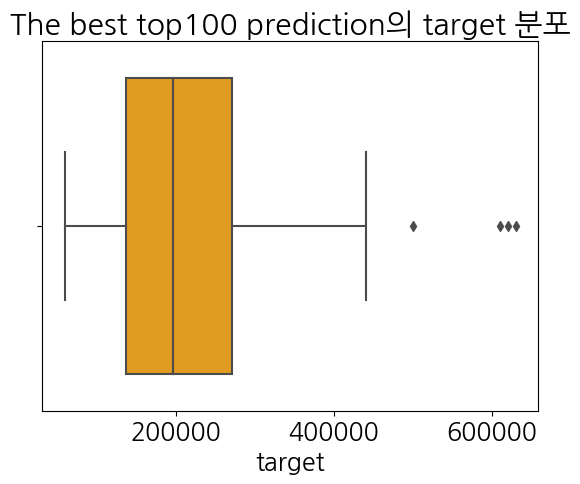

In [196]:
sns.boxplot(data=error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data=best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

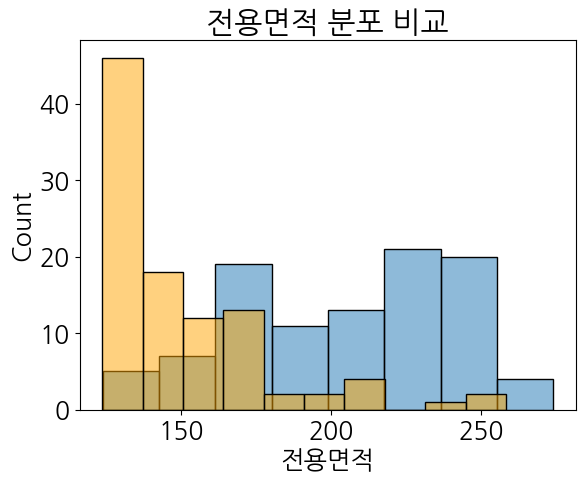

In [197]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

In [199]:
error_top100.head(10)

,복도유형,난방방식,전용면적,층,건축년도,x,y,아파트명,계약년월,mean_지상층수,...,최저층,빌딩간격,거래날차이,2020_ratio,구,동,전용면적_label,target,pred,error
272,타워형,지역난방,273.9600,16,2020,127.052217,37.526214,PH129,202204,20.000000,...,2,18,154.0,74.687709,강남구,청담동,2,1450000.0,1.118430e+06,1.099389e+11
845,계단식,지역난방,222.7600,22,2009,126.999722,37.502999,래미안퍼스티지,202211,29.178571,...,1,31,26.0,74.406403,서초구,반포동,2,840000.0,5.155947e+05,1.052388e+11
769,타워형,개별난방,264.5460,47,2020,127.044151,37.544136,아크로서울포레스트,202209,49.000000,...,3,44,170.0,48.168901,성동구,성수동1가,2,1300000.0,9.810064e+05,1.017569e+11
1871,타워형,개별난방,167.2100,5,1971,126.965018,37.521781,한강맨숀,202306,5.000000,...,-1,26,5.0,64.923778,용산구,이촌동,2,585000.0,2.925107e+05,8.554998e+10
1098,타워형,지역난방,244.3200,5,2006,127.052217,37.526214,상지리츠빌카일룸2차,202303,16.000000,...,2,18,12.0,74.687709,강남구,청담동,2,821000.0,5.453843e+05,7.596400e+10
1196,계단식,개별난방,240.3050,5,2011,127.009496,37.536978,한남더힐,202303,6.906250,...,-2,14,36.0,64.923778,용산구,한남동,2,1100000.0,8.360197e+05,6.968558e+10
1387,타워형,지역난방,224.3836,10,2006,127.054751,37.521125,동양파라곤,202304,12.000000,...,1,11,393.0,74.687709,강남구,청담동,2,680000.0,4.206207e+05,6.727761e+10
294,계단식,지역난방,198.0400,21,2009,126.999722,37.502999,래미안퍼스티지,202204,29.178571,...,1,31,5.0,74.406403,서초구,반포동,2,715000.0,4.648307e+05,6.258468e+10
1396,타워형,지역난방,196.2100,13,1976,127.027436,37.533414,현대1차,202304,13.384615,...,1,14,69.0,74.687709,강남구,압구정동,2,780000.0,5.339867e+05,6.052252e+10
585,타워형,개별난방,217.8600,42,2011,127.042680,37.545749,갤러리아포레,202206,45.000000,...,6,38,36.0,48.168901,성동구,성수동1가,2,880000.0,6.358571e+05,5.960575e+10


In [202]:
error_top100 = error_top100.rename({'pred' : 'label_pred', 'error' : 'label_error'}, axis=1)

In [204]:
best_top100 = best_top100.rename({'pred' : 'label_pred', 'error' : 'label_error'}, axis=1)

In [206]:
error_top100.to_csv('../data/interim/label_error_top100.csv', index=False)
best_top100.to_csv('../data/interim/label_best_top100.csv',index=False)

In [210]:
X_test = X_test.rename({'pred' : 'label_pred', 'error' : 'label_error'}, axis=1)

In [223]:
for col in categorical_cols:
    X_test[col] = label_encoders[col].inverse_transform(X_test[col])

In [226]:
X_test

,복도유형,난방방식,전용면적,층,건축년도,x,y,아파트명,계약년월,mean_지상층수,...,최저층,빌딩간격,거래날차이,2020_ratio,구,동,전용면적_label,target,label_pred,label_error
0,계단식,개별난방,126.6600,11,1997,127.097110,37.538173,현대프라임,202201,28.400000,...,1,29,32.0,38.478333,광진구,구의동,2,216000.0,244850.395165,8.323453e+08
1,혼합식,중앙난방,177.1200,11,1982,127.014156,37.539745,한남하이츠,202201,13.000000,...,1,13,184.0,48.168901,성동구,옥수동,2,370000.0,269695.573093,1.006098e+10
2,타워형,지역난방,196.2100,9,1976,127.027436,37.533414,현대1차,202201,13.384615,...,1,14,31.0,74.687709,강남구,압구정동,2,800000.0,666042.712963,1.794455e+10
3,계단식,개별난방,124.6250,5,2019,127.021990,37.553400,이편한세상금호파크힐스,202201,18.750000,...,1,20,18.0,48.168901,성동구,금호동1가,2,203000.0,240520.428509,1.407783e+09
4,계단식,지역난방,126.6226,10,2018,127.002073,37.479284,방배아트자이,202201,13.000000,...,1,14,164.0,74.406403,서초구,방배동,2,283000.0,315658.690219,1.066590e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,계단식,개별난방,124.8000,6,2009,127.000865,37.522819,용산파크타워,202306,40.000000,...,2,38,18.0,64.923778,용산구,용산동5가,2,310000.0,287849.853634,4.906290e+08
1881,타워형,지역난방,172.2700,10,2009,126.996352,37.490967,방배롯데캐슬로제,202306,11.000000,...,2,9,343.0,74.406403,서초구,방배동,2,345000.0,255437.753140,8.021396e+09
1882,타워형,지역난방,130.5450,32,1999,127.051498,37.488373,대림아크로빌,202306,46.000000,...,3,43,-5.0,74.687709,강남구,도곡동,2,228000.0,258057.162136,9.034330e+08
1883,타워형,개별난방,166.9800,3,1984,126.985157,37.518159,신동아,202306,13.000000,...,1,12,7.0,64.923778,용산구,서빙고동,2,367000.0,370675.099872,1.350636e+07


In [224]:
path = '/data/ephemeral/home/aistages_ml/upstage-ml-regression-07/house_price_pred/data/interim/non_label_X_test.csv'
nonlabel_X_test = pd.read_csv(path)
nonlabel_X_test

,전용면적,계약일,층,x,y,아파트명,계약년월,mean_지상층수,sum_세대수,sum_연면적,...,매매수급동향,세대수당_주차대수,년도별_세대수당_평균_주차대수,건물나이,최고층,거래날차이,2016_ratio,target,pred,error
0,79.97,12,4,127.057210,37.476763,개포6차우성,202204,5.000000,270.000000,21960.540000,...,90.8,1.925551,0.863383,36,5,129.0,63.180018,220000.0,216997.336495,9.015988e+06
1,79.97,21,2,127.057210,37.476763,개포6차우성,202204,5.000000,270.000000,21960.540000,...,90.8,1.925551,0.863383,36,5,9.0,63.180018,220000.0,219047.088771,9.080398e+05
2,79.97,27,2,127.057210,37.476763,개포6차우성,202205,5.000000,270.000000,21960.540000,...,90.1,1.925551,0.863383,36,5,36.0,63.180018,216000.0,216354.790588,1.258764e+05
3,168.42,7,2,127.076624,37.496296,개포자이,202202,21.750000,212.000000,60199.580000,...,86.9,1.194947,0.883684,19,22,172.0,63.180018,246000.0,294213.347920,2.324527e+09
4,170.32,27,11,127.076624,37.496296,개포자이,202207,21.750000,212.000000,60199.580000,...,85.0,1.194947,0.883684,19,22,170.0,63.180018,303000.0,310192.327854,5.172958e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29757,58.21,6,12,127.106981,37.599970,스마트트라움,202205,16.000000,127.000000,12999.360000,...,90.1,1.083826,1.108285,1,16,0.0,26.507618,58950.0,61133.993606,4.769828e+06
29758,58.21,6,15,127.106981,37.599970,스마트트라움,202205,16.000000,127.000000,12999.360000,...,90.1,1.082875,1.108285,1,16,0.0,26.507618,58950.0,60513.044422,2.443108e+06
29759,29.51,6,15,127.106981,37.599970,스마트트라움,202205,16.000000,127.000000,12999.360000,...,90.1,1.081925,1.108285,1,16,0.0,26.507618,33550.0,32254.422204,1.678522e+06
29760,58.21,6,15,127.106981,37.599970,스마트트라움,202205,16.000000,127.000000,12999.360000,...,90.1,1.080975,1.108285,1,16,0.0,26.507618,60550.0,60513.044422,1.365715e+03


In [225]:
nonlabel_X_test = nonlabel_X_test[['아파트명', 'target', 'pred', 'error']]
nonlabel_X_test

,아파트명,target,pred,error
0,개포6차우성,220000.0,216997.336495,9.015988e+06
1,개포6차우성,220000.0,219047.088771,9.080398e+05
2,개포6차우성,216000.0,216354.790588,1.258764e+05
3,개포자이,246000.0,294213.347920,2.324527e+09
4,개포자이,303000.0,310192.327854,5.172958e+07
...,...,...,...,...
29757,스마트트라움,58950.0,61133.993606,4.769828e+06
29758,스마트트라움,58950.0,60513.044422,2.443108e+06
29759,스마트트라움,33550.0,32254.422204,1.678522e+06
29760,스마트트라움,60550.0,60513.044422,1.365715e+03


In [228]:
concat = pd.merge(X_test, nonlabel_X_test, how='left', on=['아파트명', 'target'])
concat

,복도유형,난방방식,전용면적,층,건축년도,x,y,아파트명,계약년월,mean_지상층수,...,거래날차이,2020_ratio,구,동,전용면적_label,target,label_pred,label_error,pred,error
0,계단식,개별난방,126.660,11,1997,127.097110,37.538173,현대프라임,202201,28.400000,...,32.0,38.478333,광진구,구의동,2,216000.0,244850.395165,8.323453e+08,220683.921306,2.193912e+07
1,혼합식,중앙난방,177.120,11,1982,127.014156,37.539745,한남하이츠,202201,13.000000,...,184.0,48.168901,성동구,옥수동,2,370000.0,269695.573093,1.006098e+10,364255.751721,3.299639e+07
2,타워형,지역난방,196.210,9,1976,127.027436,37.533414,현대1차,202201,13.384615,...,31.0,74.687709,강남구,압구정동,2,800000.0,666042.712963,1.794455e+10,790818.315990,8.430332e+07
3,타워형,지역난방,196.210,9,1976,127.027436,37.533414,현대1차,202201,13.384615,...,31.0,74.687709,강남구,압구정동,2,800000.0,666042.712963,1.794455e+10,794924.430893,2.576140e+07
4,계단식,개별난방,124.625,5,2019,127.021990,37.553400,이편한세상금호파크힐스,202201,18.750000,...,18.0,48.168901,성동구,금호동1가,2,203000.0,240520.428509,1.407783e+09,207199.620632,1.763681e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2483,타워형,지역난방,172.270,10,2009,126.996352,37.490967,방배롯데캐슬로제,202306,11.000000,...,343.0,74.406403,서초구,방배동,2,345000.0,255437.753140,8.021396e+09,345450.846527,2.032626e+05
2484,타워형,지역난방,130.545,32,1999,127.051498,37.488373,대림아크로빌,202306,46.000000,...,-5.0,74.687709,강남구,도곡동,2,228000.0,258057.162136,9.034330e+08,233074.240881,2.574792e+07
2485,타워형,개별난방,166.980,3,1984,126.985157,37.518159,신동아,202306,13.000000,...,7.0,64.923778,용산구,서빙고동,2,367000.0,370675.099872,1.350636e+07,368803.396933,3.252240e+06
2486,타워형,개별난방,166.980,3,1984,126.985157,37.518159,신동아,202306,13.000000,...,7.0,64.923778,용산구,서빙고동,2,367000.0,370675.099872,1.350636e+07,361094.542385,3.487443e+07


In [229]:
new_concat = pd.merge(X_test, nonlabel_X_test, how='left', on=['아파트명', 'target'])
new_concat

,복도유형,난방방식,전용면적,층,건축년도,x,y,아파트명,계약년월,mean_지상층수,...,거래날차이,2020_ratio,구,동,전용면적_label,target,label_pred,label_error,pred,error
0,계단식,개별난방,126.660,11,1997,127.097110,37.538173,현대프라임,202201,28.400000,...,32.0,38.478333,광진구,구의동,2,216000.0,244850.395165,8.323453e+08,220683.921306,2.193912e+07
1,혼합식,중앙난방,177.120,11,1982,127.014156,37.539745,한남하이츠,202201,13.000000,...,184.0,48.168901,성동구,옥수동,2,370000.0,269695.573093,1.006098e+10,364255.751721,3.299639e+07
2,타워형,지역난방,196.210,9,1976,127.027436,37.533414,현대1차,202201,13.384615,...,31.0,74.687709,강남구,압구정동,2,800000.0,666042.712963,1.794455e+10,790818.315990,8.430332e+07
3,타워형,지역난방,196.210,9,1976,127.027436,37.533414,현대1차,202201,13.384615,...,31.0,74.687709,강남구,압구정동,2,800000.0,666042.712963,1.794455e+10,794924.430893,2.576140e+07
4,계단식,개별난방,124.625,5,2019,127.021990,37.553400,이편한세상금호파크힐스,202201,18.750000,...,18.0,48.168901,성동구,금호동1가,2,203000.0,240520.428509,1.407783e+09,207199.620632,1.763681e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2483,타워형,지역난방,172.270,10,2009,126.996352,37.490967,방배롯데캐슬로제,202306,11.000000,...,343.0,74.406403,서초구,방배동,2,345000.0,255437.753140,8.021396e+09,345450.846527,2.032626e+05
2484,타워형,지역난방,130.545,32,1999,127.051498,37.488373,대림아크로빌,202306,46.000000,...,-5.0,74.687709,강남구,도곡동,2,228000.0,258057.162136,9.034330e+08,233074.240881,2.574792e+07
2485,타워형,개별난방,166.980,3,1984,126.985157,37.518159,신동아,202306,13.000000,...,7.0,64.923778,용산구,서빙고동,2,367000.0,370675.099872,1.350636e+07,368803.396933,3.252240e+06
2486,타워형,개별난방,166.980,3,1984,126.985157,37.518159,신동아,202306,13.000000,...,7.0,64.923778,용산구,서빙고동,2,367000.0,370675.099872,1.350636e+07,361094.542385,3.487443e+07


In [237]:
label_error_sum = (new_concat['label_error'].sum())**0.5
error_sum = (new_concat['error'].sum())**0.5

print(f"label_rmse : {label_error_sum}")
print(f"just rmse : {error_sum}")
print(f"diff between label and just : {abs(label_error_sum - error_sum)}")

label_rmse : 2468356.605213096
just rmse : 821997.3025107381
diff between label and just : 1646359.3027023578


In [236]:
max(label_error_sum, error_sum)

2468356.605213096

In [234]:
new_concat[new_concat['아파트명'] == 'PH129']

,복도유형,난방방식,전용면적,층,건축년도,x,y,아파트명,계약년월,mean_지상층수,...,거래날차이,2020_ratio,구,동,전용면적_label,target,label_pred,label_error,pred,error
364,타워형,지역난방,273.96,16,2020,127.052217,37.526214,PH129,202204,20.0,...,154.0,74.687709,강남구,청담동,2,1450000.0,1.118430e+06,1.099389e+11,1.435808e+06,2.014083e+08
